In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import tree
from sklearn import ensemble # RandomForestClassifier()
# A convenience for displaying visualizations.
from IPython.display import Image

from sklearn.preprocessing import OneHotEncoder

# Packages for rendering our tree.
import pydotplus
import graphviz

# Display preferences.
%matplotlib inline
sns.set()
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

# I want to read the full contents of the dataframe
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

In [50]:
# Timing stuff
import time
from datetime import timedelta

# Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

I'm running with this [abalone data set](http://archive.ics.uci.edu/ml/datasets/Abalone). Age is the target variable, measured by the number of rings in a cross-section of the shell. (Hoping I can treat a continuous variable like age as categorical for this exercise...?)

In [51]:
abalone_df = pd.read_csv('abalone.data',header=None,
                         names=['Sex','Length','Diameter','Height','Wholeweight','Shuckedweight',
                                'Visceraweight','Shellweight','Rings'])

In [52]:
abalone_df.describe(include='all')

Sex   Length  Diameter   Height  Wholeweight  Shuckedweight  \
count   4177 4177.000 4177.000  4177.000 4177.000     4177.000         
unique  3    nan      nan       nan      nan          nan              
top     M    nan      nan       nan      nan          nan              
freq    1528 nan      nan       nan      nan          nan              
mean    NaN  0.524    0.408     0.140    0.829        0.359            
std     NaN  0.120    0.099     0.042    0.490        0.222            
min     NaN  0.075    0.055     0.000    0.002        0.001            
25%     NaN  0.450    0.350     0.115    0.442        0.186            
50%     NaN  0.545    0.425     0.140    0.799        0.336            
75%     NaN  0.615    0.480     0.165    1.153        0.502            
max     NaN  0.815    0.650     1.130    2.825        1.488            

        Visceraweight  Shellweight    Rings  
count  4177.000       4177.000     4177.000  
unique nan            nan          nan       
top    nan            nan          nan       
freq   nan            nan          nan       
mean   0.181          0.239        9.934     
std    0.110          0.139        3.224     
min    0.001          0.002        1.000     
25%    0.093          0.130        8.000     
50%    0.171          0.234        9.000     
75%    0.253          0.329        11.000    
max    0.760          1.005        29.000

In [53]:
# Simplify things a bit by turning ages/rings 1-29 into 4 bins.
# If it's not clear, I made up the bin names. :)
target_labels = ['baby','adolescent','adult','geriatric']
abalone_df['Agerange'] = pd.cut(abalone_df['Rings'],4,labels=target_labels)

In [54]:
abalone_df['Agerange'].value_counts()

adolescent    2509
baby          1407
adult         245 
geriatric     16  
Name: Agerange, dtype: int64

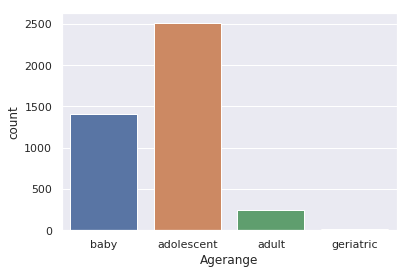

In [55]:
sns.countplot(x='Agerange',data=abalone_df)

In [56]:
abalone_df.drop('Rings',axis='columns',inplace=True)

In [57]:
Y = abalone_df['Agerange']
X = abalone_df.drop('Agerange',axis='columns')
X = pd.get_dummies(X,drop_first=True)

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [58]:
# Calculate time to create and train this decision tree
start_time = time.monotonic()

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features='auto',
    presort=True,
#    max_depth=6,
    random_state = 1337
)
decision_tree.fit(X, Y)
end_time = time.monotonic()

dc_delta = timedelta(seconds=end_time - start_time)
print(dc_delta)

0:00:00.035719


In [59]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file='abalone.dot',
    feature_names=X.columns,
    class_names=target_labels,
#    leaves_parallel=True, #unreadable 
    filled=True
)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'abalone.dot', '-o', 'abalone.png', '-Gdpi=600'])

# Display in jupyter notebook. I like this because I can then view the .png
# outside of the notebook, where it is not reduced to an unreadable size.
from IPython.display import Image
Image(filename = 'abalone.png')

In [60]:
decision_tree.score(X,Y)

1.0

## Random Forest

In [61]:
# Calculate time to create and train this decision tree
start_time = time.monotonic()

rfc = ensemble.RandomForestClassifier(criterion='entropy').fit(X,Y)
end_time = time.monotonic()

rfc_delta = timedelta(seconds=end_time - start_time)
print(rfc_delta)

0:00:00.148563


In [62]:
rfc.score(X,Y)

0.9801292793871199

In [63]:
rfc.decision_path(X)

(<4177x12892 sparse matrix of type '<class 'numpy.int64'>'
 	with 492540 stored elements in Compressed Sparse Row format>,
 array([    0,  1231,  2504,  3845,  5144,  6431,  7704,  9015, 10282,
        11567, 12892]))

Here's the difference in seconds between how long it took to train the decision tree, versus how long it took to train the random forest model. The decision tree was faster.

In [67]:
print(abs(dc_delta - rfc_delta))

0:00:00.112844


I think I was probably meant to see that the random forest didn't take much longer, but produced results that were more accurate...? I think if I had a larger data set and/or had limited the decision tree in some way (setting max_depth for instance), this may have been true. 

The single decision tree is ridiculously complex, which was a bit of a surprise given that this is a relatively small dataset with few variables. It was also, apparently, 100% accurate.

I have to imagine the trees in the random forest model are probably simpler, but more powerful when their calculations are combined. They were able to achieve between 97%-98% accuracy (it changes slightly between runs).

I spent some time trying to understand how to measure accuracy for each model, and how to understand how each is able to classify the data it handles. score() was helpful for accuracy, but the random forest seems to be a total black box as far as understanding how it reaches its decisions. The single decision tree is complex but its logic can be clearly followed.